In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv(r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\2.Data\Prepared Data\nyc_2022_essential_data.csv", index_col=False)

In [6]:
df.head()

,Unnamed: 0,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,started_at,ended_at,date,avgTemp
0,0,West End Ave & W 107 St,Mt Morris Park W & W 120 St,40.802116,-73.96818,40.804040,-73.94592,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,2022-01-21,-6.0
1,1,4 Ave & 3 St,Boerum Pl\t& Pacific St,40.673744,-73.98565,40.688488,-73.99116,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,2022-01-10,1.6
2,2,1 Ave & E 62 St,5 Ave & E 29 St,40.761227,-73.96094,40.745167,-73.98683,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,2022-01-26,-2.3
3,3,2 Ave & E 96 St,5 Ave & E 29 St,40.783962,-73.94717,40.745167,-73.98683,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2022-01-03,1.4
4,4,6 Ave & W 34 St,5 Ave & E 29 St,40.749640,-73.98805,40.745167,-73.98683,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,2022-01-22,-5.9


In [7]:
df.dtypes

Unnamed: 0              int64
start_station_name     object
end_station_name       object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
started_at             object
ended_at               object
date                   object
avgTemp               float64
dtype: object

### Creating hourly flows dataset to check imbalances

In [11]:
# 1) Change timestamps to datetime
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at']   = pd.to_datetime(df['ended_at'], errors='coerce')

# 2) Hour buckets
df['started_hour'] = df['started_at'].dt.floor('H')
df['ended_hour']   = df['ended_at'].dt.floor('H')

# 3) Count starts by station-hour
starts = (
    df.groupby(['start_station_name','start_lat','start_lng','started_hour'])
      .size()
      .rename('starts')
      .reset_index()
      .rename(columns={
          'start_station_name':'station_name',
          'start_lat':'lat',
          'start_lng':'lng',
          'started_hour':'hour'
      })
)

# 4) Count ends by station-hour
ends = (
    df.groupby(['end_station_name','end_lat','end_lng','ended_hour'])
      .size()
      .rename('ends')
      .reset_index()
      .rename(columns={
          'end_station_name':'station_name',
          'end_lat':'lat',
          'end_lng':'lng',
          'ended_hour':'hour'
      })
)

# 5) Outer-merge on station_name + hour (no station_id in your data)
hourly = starts.merge(ends, on=['station_name','hour'], how='outer', suffixes=('_start','_end'))

# 6) Coalesce metadata (prefer starts’ metadata when both exist)
hourly['lat'] = hourly['lat_start'].combine_first(hourly['lat_end'])
hourly['lng'] = hourly['lng_start'].combine_first(hourly['lng_end'])

hourly['starts'] = hourly['starts'].fillna(0).astype('int32')
hourly['ends']   = hourly['ends'].fillna(0).astype('int32')

hourly = hourly[['station_name','lat','lng','hour','starts','ends']].sort_values(['station_name','hour'])

# 7) Useful helpers for later steps
hourly['total_trips'] = hourly['starts'] + hourly['ends']
hourly['imbalance_ratio'] = np.where(
    hourly['total_trips'] > 0,
    (hourly['starts'] - hourly['ends']) / hourly['total_trips'],
    0.0
).astype('float32')

hourly.head()

,station_name,lat,lng,hour,starts,ends,total_trips,imbalance_ratio
1697,1 Ave & E 110 St,40.792328,-73.9383,2022-01-01 00:00:00,1,0,1,1.0
10355626,1 Ave & E 110 St,40.792328,-73.9383,2022-01-01 02:00:00,0,2,2,-1.0
1698,1 Ave & E 110 St,40.792328,-73.9383,2022-01-01 03:00:00,2,0,2,1.0
10355627,1 Ave & E 110 St,40.792328,-73.9383,2022-01-01 04:00:00,0,1,1,-1.0
1699,1 Ave & E 110 St,40.792328,-73.9383,2022-01-01 07:00:00,1,1,2,0.0


In [16]:
# Quick stats of imbalance column
hourly['imbalance_ratio'].describe()

count    1.177966e+07
mean    -2.051709e-01
std      6.440764e-01
min     -1.000000e+00
25%     -7.777778e-01
50%     -3.333333e-01
75%      1.333333e-01
max      1.000000e+00
Name: imbalance_ratio, dtype: float64

- average/mean = –0.205 → overall, ***stations tend to have more trips ending than starting*** (system-wide inflow bias).
- std = 0.644 → ratios vary a lot between hours/stations.
- 25% = –0.78 → 25% of station-hours are very negative, with almost 80% more ends than starts.
- 50% (median) = –0.33 → the “typical” station-hour still has a deficit of bikes (more ends).
- 75% = 0.13 → 25% of cases have slight surpluses (more starts than ends).
- In short: Most of the time, stations lean toward receiving bikes (negative ratios), but there are plenty of hours where stations swing the other way. The extreme ±1 values are the most unbalanced (all-in or all-out).

In [17]:
# Value counts binned
hourly['imbalance_ratio'].round(1).value_counts().sort_index()

-1.0    1480636
-0.9     890127
-0.8     973556
-0.7     571714
-0.6     441027
-0.5     589910
-0.4     160562
-0.3     964096
-0.2     437515
-0.1     399808
 0.0    1705150
 0.1     318613
 0.2     324933
 0.3     451989
 0.4      99433
 0.5     185037
 0.6      98806
 0.7      57734
 0.8      26400
 0.9       5561
 1.0    1597049
Name: imbalance_ratio, dtype: int64

- Most stations lean toward being receivers (negative imbalance).
- But there are plenty of one-sided extremes (all-in or all-out hours), which are the riskiest for disruption.
- Balanced hours (0.0) are common, but that can also include “low demand” cases where just 1 start & 1 end cancel each other out.

In [27]:
# Filter out low-demand station-hours
demand_threshold = 10
hourly_filtered = hourly[hourly['total_trips'] >= demand_threshold].copy()

# Recheck distribution
hourly_filtered['imbalance_ratio'].round(1).value_counts().sort_index()

-1.0     59202
-0.9    890127
-0.8    568916
-0.7     23043
-0.6     49827
-0.5     73445
-0.4    104606
-0.3    147090
-0.2    233437
-0.1    261457
 0.0    259172
 0.1    200192
 0.2    154230
 0.3     87924
 0.4     59885
 0.5     40828
 0.6     26950
 0.7     12101
 0.8     12298
 0.9      5561
 1.0      2266
Name: imbalance_ratio, dtype: int64

- Strong negative imbalance is common: –0.9 (~ 890K) and –0.8 (~ 569K) dominate → many station-hours see heavy inflows (stations acting as sinks).

- Mild negatives still sizeable: –0.3 to –0.1 range (~640K combined) shows more balanced but still inflow-leaning hours.

- Balanced hours: 0.0 (~259K), a noticeable cluster of roughly balanced trips.

- Positive imbalance is much smaller: Only ~200K–150K hours in the 0.1–0.3 range.

- Very few strong positives: e.g. 0.8 (~ 12K);  0.9 (~ 5.5K);  1.0 (~ 2.3K).

***Negative imbalances outnumber positives by a wide margin, confirming that bike accumulation is far more common than depletion once low-demand noise is filtered out***.

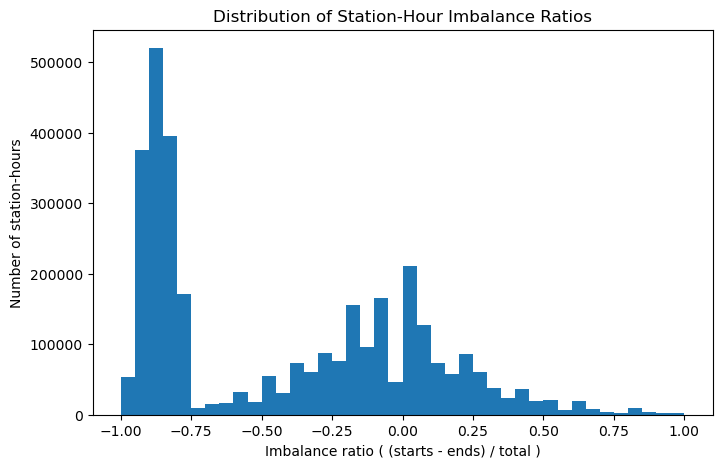

In [25]:
# histogram for the imbalance ratio distribution (after filtering)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
hourly_filtered['imbalance_ratio'].hist(bins=40)
plt.xlabel("Imbalance ratio ( (starts - ends) / total )")
plt.ylabel("Number of station-hours")
plt.title("Distribution of Station-Hour Imbalance Ratios")
plt.grid(False)
plt.show()


- A huge spike around –0.9 to –0.8, confirming that many station-hours are strongly sink behavior (far more ends than starts).

- A smaller bump around 0 → balanced hours.

- A long, thin right tail → some stations act as strong sources, but far less common.

***Operationally, this says: Bike accumulation is the dominant risk. Redistribution trucks will mostly be busy removing bikes from overloaded stations rather than refilling empty ones***.

### Building dataset for Kepler map

In [28]:
# Columns Kepler needs: lat, lng, time, plus metrics for color/size
kepler_df = hourly_filtered.loc[:, [
    'station_name','lat','lng','hour','starts','ends','total_trips','imbalance_ratio'
]].rename(columns={
    'hour':'timestamp'
})

# Save for Kepler
out_path = "kepler_station_hourly.csv"
kepler_df.to_csv(out_path, index=False)
out_path

'kepler_station_hourly.csv'

### Building line chart

In [32]:
import geopandas as gpd
from shapely.geometry import Point

# 1) Unique stations
stations = (
    hourly[['station_name','lat','lng']]
    .dropna()
    .drop_duplicates()
    .reset_index(drop=True)
)

# 2) Stations as GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=[Point(xy) for xy in zip(stations['lng'], stations['lat'])],
    crs="EPSG:4326"
)

# 3) Load NTA GeoJSON (update path)
nta = gpd.read_file(r"C:/Users/magia/OneDrive/Desktop/NY_Citi_Bike/2.Data/Prepared Data/nyc_nta_2020.geojson").to_crs("EPSG:4326")

# 4) Spatial join: stations -> NTA (using NTA2020 + NTAName)
stations_nta = gpd.sjoin(
    gdf_stations, 
    nta[['NTA2020','NTAName','BoroName','geometry']], 
    how='left', 
    predicate='within'
)
# 5) Lookup table
station_to_nta = stations_nta[['station_name','lat','lng','NTA2020','NTAName','BoroName']].rename(
    columns={'NTA2020':'nta_code','NTAName':'nta_name','BoroName':'borough'}
)
station_to_nta.head()

,station_name,lat,lng,nta_code,nta_name,borough
0,1 Ave & E 110 St,40.792328,-73.938300,MN1102,East Harlem (North),Manhattan
1,1 Ave & E 110 St,40.792480,-73.938190,MN1102,East Harlem (North),Manhattan
2,1 Ave & E 110 St,40.792427,-73.938390,MN1102,East Harlem (North),Manhattan
3,1 Ave & E 110 St,40.792152,-73.937744,MN1101,East Harlem (South),Manhattan
4,1 Ave & E 110 St,40.792347,-73.937870,MN1101,East Harlem (South),Manhattan


In [33]:
# Build horly demand by NTA table

# 1) Attach NTA to each station-hour
hourly_nta = (
    hourly.merge(
        station_to_nta, 
        on=['station_name','lat','lng'], 
        how='left'
    )
    .dropna(subset=['nta_name'])   # drop stations outside NYC polygons, if any
)

# 2) Aggregate trips by NTA + hour (timestamp hour)
nta_hourly = (
    hourly_nta
    .groupby(['nta_name','borough','hour'], as_index=False)[['starts','ends','total_trips']]
    .sum()
    .sort_values(['nta_name','hour'])
)

# 3) (Optional) “typical day” profile → average by hour-of-day across the year
nta_hourly['hour_of_day'] = nta_hourly['hour'].dt.hour
nta_daily_profile = (
    nta_hourly
    .groupby(['nta_name','borough','hour_of_day'], as_index=False)[['starts','ends','total_trips']]
    .mean()
    .rename(columns={'total_trips':'avg_total_trips','starts':'avg_starts','ends':'avg_ends'})
)

nta_hourly.head(), nta_daily_profile.head()

(            nta_name borough                hour  starts  ends  total_trips  \
 0  Astoria (Central)  Queens 2022-01-01 00:00:00       3     0            3   
 1  Astoria (Central)  Queens 2022-01-01 01:00:00      11    11           22   
 2  Astoria (Central)  Queens 2022-01-01 02:00:00       9    17           26   
 3  Astoria (Central)  Queens 2022-01-01 03:00:00       5     8           13   
 4  Astoria (Central)  Queens 2022-01-01 04:00:00       4     5            9   
 
    hour_of_day  
 0            0  
 1            1  
 2            2  
 3            3  
 4            4  ,
             nta_name borough  hour_of_day  avg_starts   avg_ends  \
 0  Astoria (Central)  Queens            0   11.021978  13.969780   
 1  Astoria (Central)  Queens            1    6.296399   7.606648   
 2  Astoria (Central)  Queens            2    3.988201   4.734513   
 3  Astoria (Central)  Queens            3    2.549206   2.717460   
 4  Astoria (Central)  Queens            4    2.694704   3.00311

### Multi-line chart for the top N busiest NTAs in NYC

In [ ]:
import matplotlib.pyplot as plt

# 1) Pick top N NTAs by avg_total_trips
N = 12
top_nta = (
    nta_daily_profile.groupby('nta_name', as_index=False)['avg_total_trips']
    .mean()
    .sort_values('avg_total_trips', ascending=False)
    .head(N)['nta_name']
)

# 2) Pivot to wide (rows: hour_of_day, columns: nta_name)
plot_df = (
    nta_daily_profile[nta_daily_profile['nta_name'].isin(top_nta)]
    .pivot_table(index='hour_of_day', columns='nta_name', values='avg_total_trips')
    .sort_index()
)

# 3) Plot
plt.figure(figsize=(10,6))
plot_df.plot(ax=plt.gca())
plt.title('CitiBike — Avg Trips by Hour (Top NTAs)')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Total Trips per Hour')
plt.legend(title='NTA', ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


In [36]:
# number of unique NTA names
nta['NTAName'].nunique()

262

In [37]:
# list NTAs that have CitiBike stations

nta_with_stations = (
    station_to_nta
    .dropna(subset=['nta_name'])
    .groupby(['nta_code','nta_name','borough'])
    .size()
    .reset_index(name='num_stations')
    .sort_values('num_stations', ascending=False)
)

print("Total NTAs with stations:", nta_with_stations.shape[0])
nta_with_stations.head(15)

Total NTAs with stations: 113


,nta_code,nta_name,borough,num_stations
70,MN0502,Midtown-Times Square,Manhattan,214088
67,MN0401,Chelsea-Hudson Yards,Manhattan,116696
69,MN0501,Midtown South-Flatiron-Union Square,Manhattan,100249
66,MN0303,East Village,Manhattan,92419
58,MN0101,Financial District-Battery Park City,Manhattan,72827
73,MN0603,Murray Hill-Kips Bay,Manhattan,69305
62,MN0202,Greenwich Village,Manhattan,68603
74,MN0604,East Midtown-Turtle Bay,Manhattan,66201
68,MN0402,Hell's Kitchen,Manhattan,65914
77,MN0702,Upper West Side (Central),Manhattan,60104


In [39]:
nta_with_stations['nta_name'].nunique()

113

In [43]:
# save nta_daily_profile dataset for line chart
nta_daily_profile.to_pickle("nta_daily_profile.pkl")

### Adding seasons

In [44]:
# starting from `hourly_nta` (has columns: nta_name, borough, hour, total_trips, starts, ends)
hourly_nta['hour_of_day'] = hourly_nta['hour'].dt.hour
m = hourly_nta['hour'].dt.month

# Season rules:
# winter: Dec + Jan–Apr; spring: May; summer: Jun–Sep; fall: Oct–Nov
season = np.select(
    [
        (m==12) | ((m>=1) & (m<=4)),
        (m==5),
        (m>=6) & (m<=9),
        (m>=10) & (m<=11)
    ],
    ['winter','spring','summer','fall'],
    default='unknown'
)
hourly_nta['season'] = season

# Average "typical day" by NTA × season × hour_of_day
nta_seasonal_profile = (
    hourly_nta
    .groupby(['nta_name','borough','season','hour_of_day'], as_index=False)[['starts','ends','total_trips']]
    .mean()
    .rename(columns={'total_trips':'avg_total_trips','starts':'avg_starts','ends':'avg_ends'})
)

# save for Streamlit
nta_seasonal_profile.to_pickle("nta_seasonal_profile.pkl")

In [47]:
hourly_nta.dtypes

station_name               object
lat                       float64
lng                       float64
hour               datetime64[ns]
starts                      int32
ends                        int32
total_trips                 int32
imbalance_ratio           float32
nta_code                   object
nta_name                   object
borough                    object
hour_of_day                 int64
season                     object
dtype: object

In [49]:
# Create daily and seasonal imbalance profiles

#Daily (average day)
daily = (hourly_nta
         .groupby(['nta_name','borough','hour_of_day'], as_index=False)[['starts','ends']]
         .sum())
den = (daily['starts'] + daily['ends']).replace(0, np.nan)
daily['imbalance_ratio'] = ((daily['starts'] - daily['ends']) / den).fillna(0.0).clip(-1,1)
nta_daily_imbalance = daily[['nta_name','borough','hour_of_day','imbalance_ratio']]

# Seasonal
seasonal = (hourly_nta
            .groupby(['nta_name','borough','season','hour_of_day'], as_index=False)[['starts','ends']]
            .sum())
den = (seasonal['starts'] + seasonal['ends']).replace(0, np.nan)
seasonal['imbalance_ratio'] = ((seasonal['starts'] - seasonal['ends']) / den).fillna(0.0).clip(-1,1)
nta_seasonal_imbalance = seasonal[['nta_name','borough','season','hour_of_day','imbalance_ratio']]

# Save
nta_daily_imbalance.to_pickle("nta_daily_imbalance.pkl")
nta_seasonal_imbalance.to_pickle("nta_seasonal_imbalance.pkl")

In [51]:
station_to_nta.to_csv("station_to_nta.csv")